# Creating vector representations of SEU Neuron Morphologies

In [77]:
import getpass
import jwt

import numpy as np
import pandas as pd

from kgforge.core import KnowledgeGraphForge
from kgforge.specializations.resources import Dataset

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from bluegraph import PandasPGFrame
from bluegraph.preprocess import ScikitLearnPGEncoder
from bluegraph.downstream.utils import transform_to_2d, plot_2d
from bluegraph.preprocess import CooccurrenceGenerator
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder
from bluegraph.backends.networkx import NXCommunityDetector
from bluegraph.downstream import EmbeddingPipeline
from bluegraph.downstream.similarity import SimilarityProcessor

In [2]:
def get_encoder_features(prop_name, encoder, last_index):
    if encoder is None or isinstance(encoder, StandardScaler):
        return {last_index: f"{prop_name}_IDENTITY"}, last_index + 1
    if isinstance(encoder, TfidfVectorizer):
        return (
            {
                i + last_index: f"{prop_name}_WORD_{f}"
                for i, f in enumerate(encoder.get_feature_names())
            },
            last_index + len(encoder.get_feature_names())
        )
    elif isinstance(encoder, MultiLabelBinarizer):
        return (
            {
                i + last_index: f"{prop_name}_CLASS_{c}"
                for i, c in enumerate(encoder.classes_)
            },
            last_index + len(encoder.classes_)
        )
    
    else:
        return {}, last_index

def explain_property_coordinates(encoder, graph):
    last_index = 0
    property_coordinates = {}
    for p in graph.node_properties():
        if p in encoder._node_encoders:
            res, new_index = get_encoder_features(
                p, encoder._node_encoders[p], last_index)
            property_coordinates.update(res)
            last_index = new_index
    return property_coordinates

## Load morphologies from Nexus

In [3]:
TOKEN = getpass.getpass()

········


In [4]:
forge = KnowledgeGraphForge("configs/new-forge-config.yaml",
                            token=TOKEN,
                            bucket="bbp-external/seu")

In [5]:
morphologies = forge.search({"type": "NeuronMorphology"}, limit=None)

In [6]:
morphologies_df = forge.as_dataframe(morphologies)[[
    "id",
    "brainLocation.brainRegion.id",
    "brainLocation.coordinatesInBrainAtlas.valueX.value",
    "brainLocation.coordinatesInBrainAtlas.valueY.value",
    "brainLocation.coordinatesInBrainAtlas.valueZ.value",
    "somaNumberOfPoints.value",
    "neuriteFeature",
    "subject.name"
]]

In [7]:
forge = KnowledgeGraphForge(
    "configs/new-forge-config.yaml",
    token=TOKEN,
    bucket="neurosciencegraph/datamodels")

In [8]:
brain_region_resources = [
    forge.retrieve(el) for el in morphologies_df["brainLocation.brainRegion.id"]
]

In [9]:
brain_region_notation = {
    r.id: (r.notation, r.prefLabel)
    for r in brain_region_resources
}

In [10]:
def get_notation(region_id):
    if region_id not in brain_region_notation:
        r = forge.retrieve(region_id)
        brain_region_notation[r.id] = (r.notation, r.prefLabel)
    return brain_region_notation[region_id][0]

In [11]:
def get_neurite_features(data):
    
    result = {
        "has_Axon_feature": 0,
        "has_BasalDendrite_feature": 0,
        "has_ApicalDendrite_feature": 0
    }
    
    def _process_data(el, prefix):
        result[f"{prefix}_cumulatedLength"] = el["cumulatedLength"]["value"]
        result[f"{prefix}_longestBranchLength"] = el["longestBranchLength"]["value"]
        result[f"{prefix}_longestBranchNumberOfNodes"] = el["longestBranchNumberOfNodes"]
        result[f"{prefix}_numberOfProjections"] = el["numberOfProjections"]
        result[f"{prefix}_projectionBrainRegion"] = {
            get_notation(r["id"]) for r in el["projectionBrainRegion"]
        } if isinstance(el["projectionBrainRegion"], list) else {get_notation(el["projectionBrainRegion"]["id"])}
        result[f"{prefix}_traversedBrainRegion"] = {
            get_notation(r["id"]) for r in el["traversedBrainRegion"]
        } if isinstance(el["traversedBrainRegion"], list) else {get_notation(el["traversedBrainRegion"]["id"])}

    for el in data:
        result["has_" + el["type"] + "_feature"] = 1
        _process_data(el, el["type"])

    return result

In [12]:
neurite_features = morphologies_df["neuriteFeature"].apply(get_neurite_features).tolist()

In [13]:
neurite_feature_df = pd.DataFrame(neurite_features)

In [14]:
morphologies_df["brainLocation.brainRegion.id"] = morphologies_df["brainLocation.brainRegion.id"].apply(
    lambda x: brain_region_notation[x][0])

## Create a property graph (only nodes)

In [15]:
nodes = pd.concat(
    [morphologies_df, neurite_feature_df], axis=1).drop(
        columns=["neuriteFeature"]).rename(columns={"id": "@id"}).set_index("@id")

In [16]:
frame = PandasPGFrame()

In [17]:
frame._nodes = nodes

In [18]:
categorical_props = [
    "brainLocation.brainRegion.id",
    "subject.name",
    "has_Axon_feature",
    "has_BasalDendrite_feature",
    "has_ApicalDendrite_feature",
    "BasalDendrite_projectionBrainRegion",
    "BasalDendrite_traversedBrainRegion",
    "ApicalDendrite_projectionBrainRegion",
    "ApicalDendrite_traversedBrainRegion",
    "Axon_projectionBrainRegion",
    "Axon_traversedBrainRegion",
]

In [19]:
for column in nodes.columns:
    if column != "@type":
        if column not in categorical_props:
            frame.node_prop_as_numeric(column)
        else:
            frame.node_prop_as_category(column)

In [20]:
frame.rename_node_properties({
    p: p.replace(".", "_")
    for p in frame.node_properties()
})

## Create axon co-projection edges and use graph embedding

In [21]:
gen = CooccurrenceGenerator(frame)
edges = gen.generate_from_nodes(
    "Axon_projectionBrainRegion",
    compute_statistics=["frequency"])

In [22]:
edges = edges[edges["frequency"] > 3]

In [23]:
frame._edges = edges
frame.edge_prop_as_numeric("frequency")

## Create embedding pipeline

### 1. Encode properties

In [24]:
encoder = ScikitLearnPGEncoder(
    node_properties=frame.node_properties(),
    missing_numeric="impute",
    imputation_strategy="mean",
    reduce_node_dims=True,
    n_node_components=64)

In [29]:
encoded_frame = encoder.fit_transform(frame)

Explained variance of data

In [37]:
sum(encoder.node_reducer.explained_variance_ratio_)

0.8951006693746009

Let's plot a 2D projection of what we have got

In [47]:
X = np.array(encoded_frame._nodes["features"].tolist())
features_2d = transform_to_2d(X)

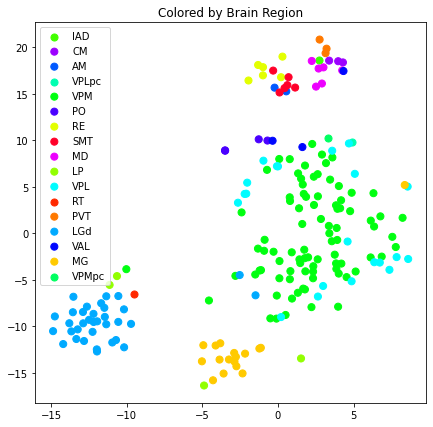

In [48]:
plot_2d(
    frame, vectors=features_2d, label_prop="brainLocation_brainRegion_id",
    title="Colored by Brain Region")

### 2. Embed nodes

In [49]:
attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="features",
    length=5, number_of_walks=10,
    epochs=10, embedding_dimension=128, edge_weight="frequency")

In [50]:
attri2vec_embedding = attri2vec_embedder.fit_model(encoded_frame)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [51]:
frame.add_node_properties(
    attri2vec_embedding.rename(columns={"embedding": "attri2vec"}))

In [52]:
attri2vec_2d = transform_to_2d(frame._nodes["attri2vec"].tolist())

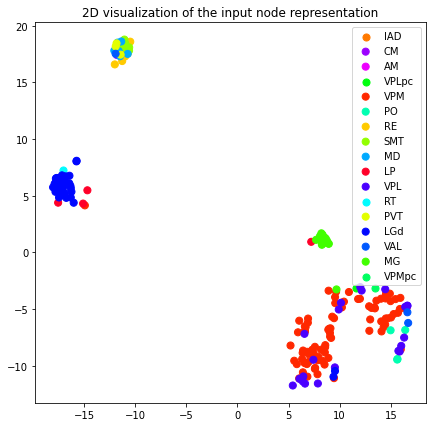

In [54]:
plot_2d(frame, vectors=attri2vec_2d, label_prop="brainLocation_brainRegion_id")

### 3. Create and save the embedding pipeline

In [65]:
pipeline = EmbeddingPipeline(
    preprocessor=encoder,
    embedder=attri2vec_embedder,
    similarity_processor=SimilarityProcessor(similarity="euclidean", dimension=128))

In [67]:
pipeline.save("SEU_morph_attri2vec_euclidean", compress=True)

INFO:tensorflow:Assets written to: SEU_morph_attri2vec_euclidean/embedder/model/assets


### 5. TODO: Push the model into the model catalog

In [70]:
forge = KnowledgeGraphForge(
    "configs/new-forge-config.yaml",
    token=TOKEN,
    bucket="dke/embedding-pipelines")

In [71]:
def get_agent(token):
    agent_data = jwt.decode(token, verify=False)
    agent = forge.reshape(
        forge.from_json(agent_data), keep=[
            "name", "email", "sub", "preferred_username"])
    agent.id = agent.sub
    agent.type = "Person"
    return agent

In [72]:
def push_model(forge, agent, name, description, distribution):
    # Create a new model resource
    model_resource = Dataset(
        forge,
        name=name,
        description=description)
    model_resource.type = ["Dataset", "EmbeddingModel"]
    # Add distrubution
    model_resource.add_distribution(
        distribution, content_type="application/octet-stream")
    # Add contribution
    model_resource.add_contribution(agent, versioned=False)
    model_resource.contribution.hadRole = "Engineer"

    forge.register(model_resource)

In [75]:
agent = get_agent(TOKEN)

In [78]:
push_model(
    forge, agent, "SEU NeuronMorphology Embedding",
    "Node embedding model built on the SEU neuron morphology dataset resources",
    "SEU_morph_attri2vec_euclidean.zip")

<action> _register_one
<succeeded> True


## Visualize the graph in Gephi

In [437]:
frame.export_to_gephi(
    "seu_morphologies_co_proj",
    node_attr_mapping={
        "brainLocation_brainRegion_id": "Region"
    },
    edge_attr_mapping={
        "frequency": "weight"
    })

<img src="figures/neu_co_proj_illustration.png">

## Detect communities

In [430]:
det = NXCommunityDetector(frame, directed=False)

In [435]:
det.detect_communities(
    strategy='louvain', weight="frequency", write=True, write_property="community")